# Lab 4 Image Registration

In this lab exercise, you will look at image registration using hand-picked selected features.

You are asked to write a short (no more than 2 pages) report of your work, answering specific questions, and showing example images. This work is not assessed (it will not count towards your module mark) but you will get formative feedback. 

In this exercise, we will be performing image registration on two different views of a fish embryo. To achieve the following steps need to be taken:

- Load in the two images:
    - fish-vis.tif (transmission image, visible light)
    - fish-cfp-#.tif (the floating image that is to be registered to the base image. This is a grey-level version of a fluorescence image with Cyan Fluorescent Protein - CFP)

- Use the existing skeleton code to find matching key points across the two images.
    - This may involve some trial and error of manually entering coordinates and updating the figure

- Perform transformation estimation using the estimated keypoints
- Register the two images using a warp function
- Display an overlayed image (blue and red) 

Example of overlay:

![Example image](example.png)

In [2]:

from skimage import io
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray, gray2rgb

# Load Images

img_vis = io.imread('FishImageFiles/fish-vis.tif') # replace None
img_cfp = io.imread('FishImageFiles/fish-cfp-1.tif')

In [3]:
print(img_vis.shape)
print(img_cfp.shape)


(331, 549)
(331, 549, 3)


In [4]:
img_vis = img_vis / 255
img_cfp = rgb2gray(img_cfp)

(331, 549)


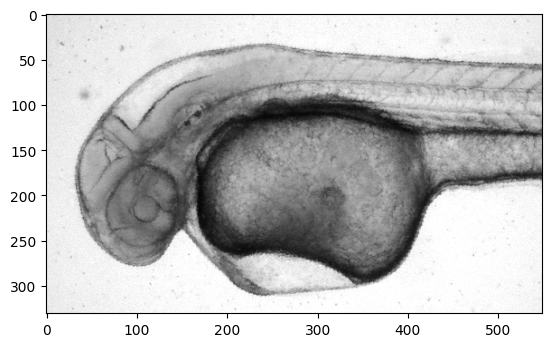

In [5]:
print(img_vis.shape)
plt.imshow(img_vis, cmap='gray')

(331, 549)


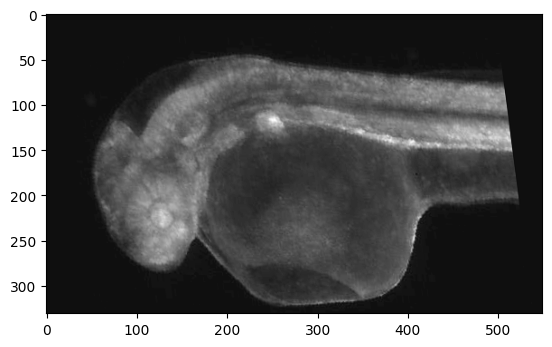

In [30]:
print(img_cfp.shape)
plt.imshow(img_cfp, cmap='gray')

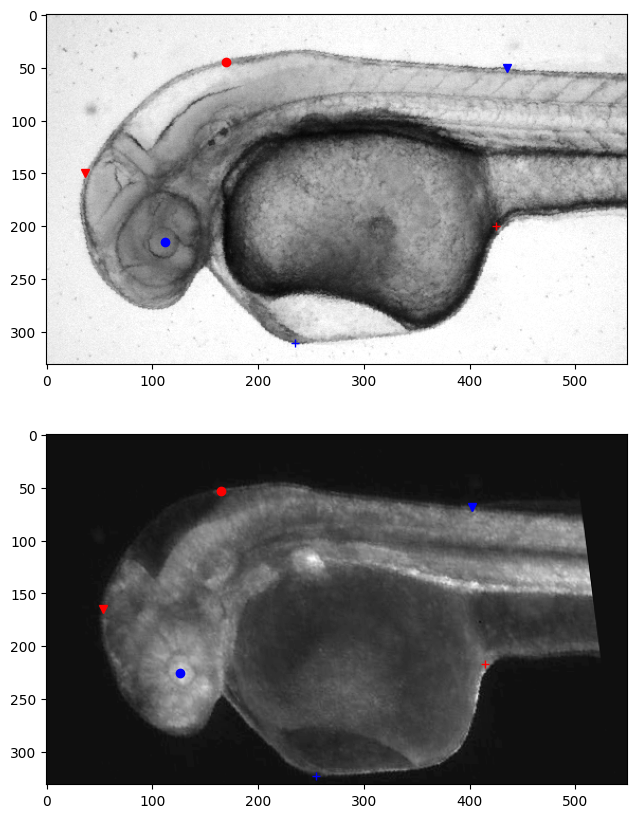

In [33]:
## Extract Keypoints

fig,axes = plt.subplots(2, 1,figsize=(10, 10))

#Fill in the key points array in the form as follows [[x1,y1],[x2,y2],[x3,y3]]
keypointsA = [(170,45),(112,215), (36, 150), (435,50), (425, 200), (235,310)]
keypointsB = [(165,53),(126,225), (53, 165), (402,68), (415, 217), (255,323)]

# keypointsA = [[33, 167], [240, 36], [423, 53], [441, 192], [227, 310], [111, 217]]
# keypointsB = [[55, 181], [233, 50], [413, 71], [425, 217], [248, 320], [131, 226]]

# Display the key points
symbols = ['ro','bo','rv','bv','r+','b+']
ax = axes.ravel()

for i in range(0,len(keypointsA)):
    ax[0].plot(keypointsA[i][0],keypointsA[i][1],symbols[i])
for i in range(0,len(keypointsB)):    
    ax[1].plot(keypointsB[i][0],keypointsB[i][1],symbols[i])

ax[0].imshow(img_vis, cmap='gray')
ax[1].imshow(img_cfp, cmap='gray')

In [34]:
## Check shape of images
print(img_vis.shape, img_vis.max())
print(img_cfp.shape, img_cfp.max())


(331, 549) 1.0
(331, 549) 0.6176470588235293


In [35]:
## Image and key points pairs
images_pairs = {
    'vis': (img_vis, np.array(keypointsA, dtype=np.float32)),
    'cfp': (img_cfp, np.array(keypointsB, dtype=np.float32))
}

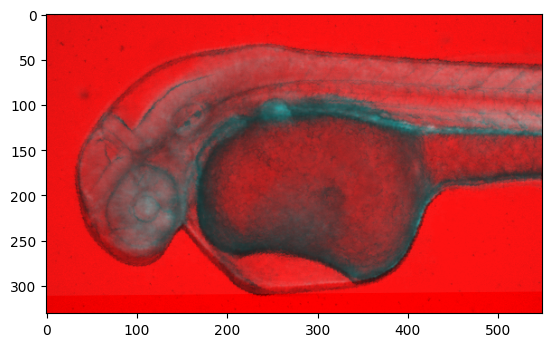

In [87]:
# Perform transformation estimation using the estimated keypoints
from skimage.transform import estimate_transform
from skimage.transform import warp
import cv2 as cv


def estimate_transform_and_overlap(images_pairs, method='projective'):
    # Target and source image
    # NOTE: I need to go from img_cfp (2nd one) to img_vis (1st one)
    image_source, source_points = images_pairs['cfp']  
    image_target, target_points = images_pairs['vis']

    nr, nc = image_source.shape

    # Estimate the transformation matrix
    transform = estimate_transform(method, source_points, target_points)
    # transform, _ = cv.estimateAffine2D(source_points, target_points)

    # Apply the transformation to the image
    # NOTE: wrap takes the inverse map as input lol lol lol. For this reason, 
    # I need to use transform.inverse hahahahahahahhaHHAHAHAHAH
    img_transformed = warp(image_source, transform.inverse)
    # img_transformed = cv.warpAffine(image_source, transform, (nc, nr))

    def overlap_images(transformed, target):
        overlap_image = np.zeros((nr, nc, 3))
        overlap_image[..., 0] = target
        overlap_image[..., 1] = transformed
        overlap_image[..., 2] = transformed
        return overlap_image

    overlaped_image = overlap_images(img_transformed, image_target)

    plt.imshow(overlaped_image)
    plt.show()

    return image_source, img_transformed, image_target

image_source, img_transformed, image_target = estimate_transform_and_overlap(images_pairs)

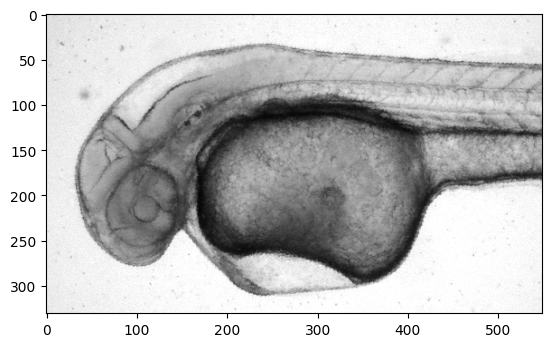

In [40]:
plt.imshow(image_target, cmap='gray')

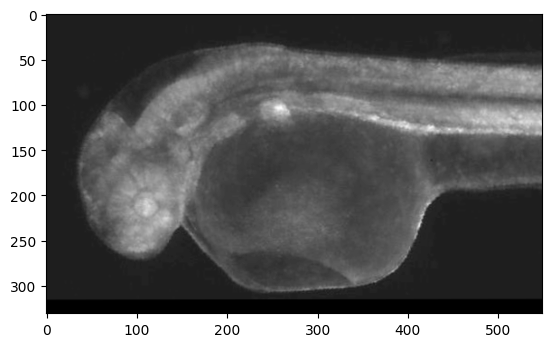

In [39]:
plt.imshow(img_transformed, cmap='gray')

##### Question 1: What is the effect of increasing/decreasing the number of chosen control points in registration accuracy?

Using 4 keypoints


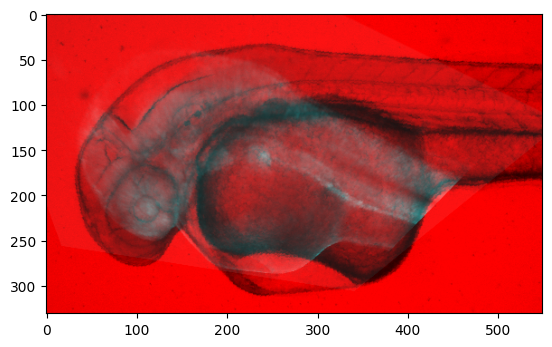

Using 5 keypoints


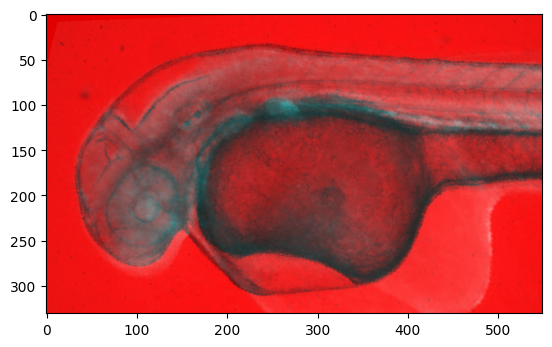

Using 6 keypoints


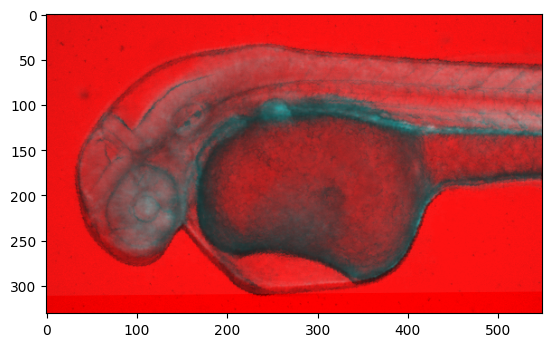

In [56]:
## Image and key points pairs

for idx in [3, 4, 5]:
    print(f"Using {idx+1} keypoints")
    images_pairs = {
        'vis': (img_vis, np.array(keypointsA[:idx], dtype=np.float32)),
        'cfp': (img_cfp, np.array(keypointsB[:idx], dtype=np.float32))
    }
    image_source, img_transformed, image_target = estimate_transform_and_overlap(images_pairs)

##### Question 2: How would you evaluate the accuracy of your registration?

During class we studied 3 ways to evaluate the accuracy
- Mean Squeare Difference (MSD)
- Mutal Information
- Normalised cross-correlation

In our case, we have diiferent intensities MSD could not work well. I tried the two other ways.

In [50]:
print(image_target.max(), image_target.min())
print(img_transformed.max(), img_transformed.min())

1.0 0.08235294117647059
0.6136796742366235 0.0


Normalized Mutual Information: 1.0979


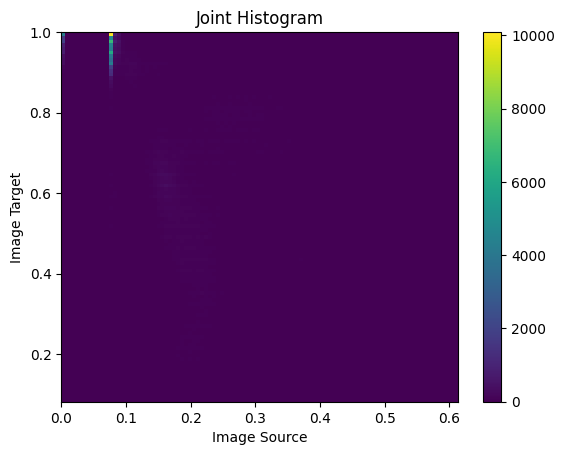

In [81]:
from skimage.metrics import normalized_mutual_information, mean_squared_error

def joint_histogram(img_source, img_target):

    # Visualize the joint histogram
    plt.hist2d(img_source.ravel(), img_target.ravel(), bins=100)
    plt.colorbar()
    plt.xlabel('Image Source')
    plt.ylabel('Image Target')
    plt.title('Joint Histogram')
    plt.show()

mi = normalized_mutual_information(img_transformed, image_target)
print(f"Normalized Mutual Information: {mi:.4f}")
joint_histogram(img_transformed, image_target)

In [85]:
from skimage.feature import match_template
from skimage.metrics import normalized_root_mse


def match_template_and_evaluate(img1, img2):
    # Assuming img1 and img2 are the two images you want to compare
    result = match_template(img1, img2)

    # Calculate the NCC score
    ncc_score = result.max()

    # Calculate the Normalized Root Mean Squared Error (NRMSE) as an additional evaluation metric
    nrmse = normalized_root_mse(img1, img2)

    return ncc_score, nrmse

Using 4 keypoints


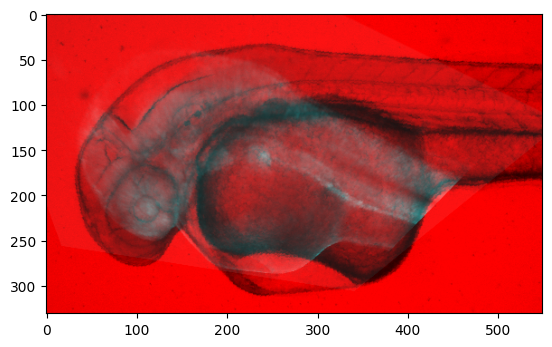

Mean Squared Error: 0.4843
Normalized Mutual Information: 1.0687
Normalized Cross-Correlation (NCC) score: -0.6270
Normalized Root Mean Squared Error (NRMSE): 4.3662
Using 5 keypoints


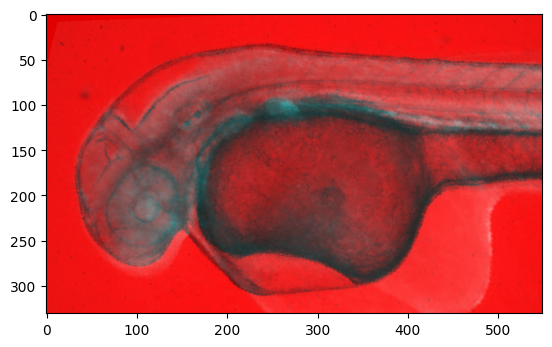

Mean Squared Error: 0.3947
Normalized Mutual Information: 1.0719
Normalized Cross-Correlation (NCC) score: -0.5185
Normalized Root Mean Squared Error (NRMSE): 3.0780
Using 6 keypoints


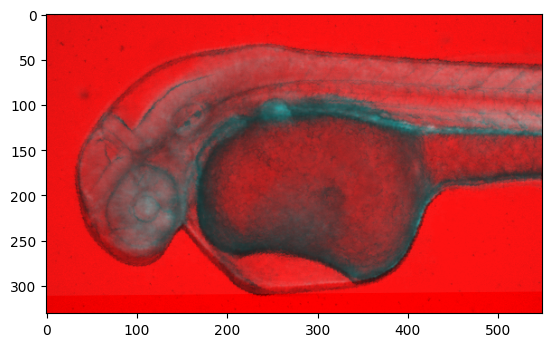

Mean Squared Error: 0.4280
Normalized Mutual Information: 1.0979
Normalized Cross-Correlation (NCC) score: -0.6784
Normalized Root Mean Squared Error (NRMSE): 3.3978


In [86]:
## Image and key points pairs

for idx in [3, 4, 5]:
    print(f"Using {idx+1} keypoints")
    images_pairs = {
        'vis': (img_vis, np.array(keypointsA[:idx], dtype=np.float32)),
        'cfp': (img_cfp, np.array(keypointsB[:idx], dtype=np.float32))
    }
    image_source, img_transformed, image_target = estimate_transform_and_overlap(images_pairs)
    
    mse = mean_squared_error(img_transformed, image_target)
    print(f"Mean Squared Error: {mse:.4f}")

    mi = normalized_mutual_information(img_transformed, image_target)
    print(f"Normalized Mutual Information: {mi:.4f}")

    ncc_score, nrmse = match_template_and_evaluate(img_transformed, image_target)
    print(f"Normalized Cross-Correlation (NCC) score: {ncc_score:.4f}")
    print(f"Normalized Root Mean Squared Error (NRMSE): {nrmse:.4f}")

##### Question 3: Other than Projective Transform, what are the other options and which one do you think works best?

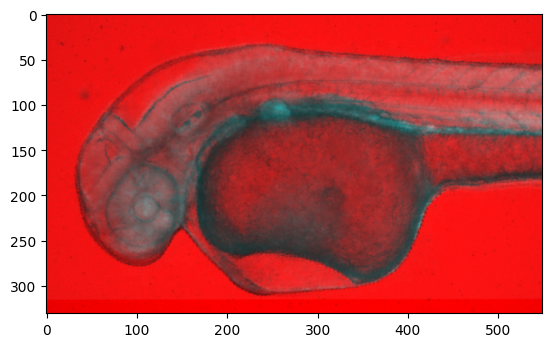

In [89]:
## Image and key points pairs
images_pairs = {
    'vis': (img_vis, np.array(keypointsA, dtype=np.float32)),
    'cfp': (img_cfp, np.array(keypointsB, dtype=np.float32))
}
results = estimate_transform_and_overlap(images_pairs, method='projective')

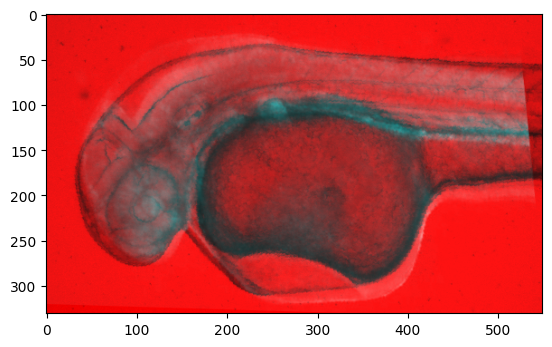

In [90]:
## Image and key points pairs
images_pairs = {
    'vis': (img_vis, np.array(keypointsA, dtype=np.float32)),
    'cfp': (img_cfp, np.array(keypointsB, dtype=np.float32))
}
results = estimate_transform_and_overlap(images_pairs, method='similarity')

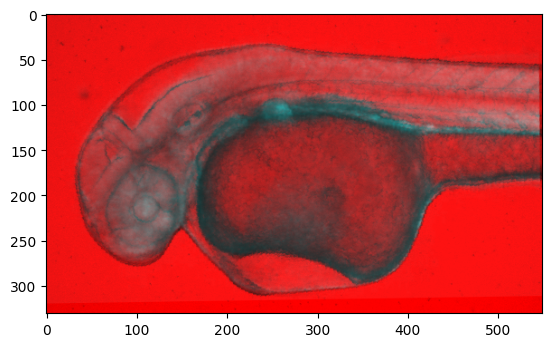

In [91]:
## Image and key points pairs
images_pairs = {
    'vis': (img_vis, np.array(keypointsA, dtype=np.float32)),
    'cfp': (img_cfp, np.array(keypointsB, dtype=np.float32))
}
results = estimate_transform_and_overlap(images_pairs, method='affine')

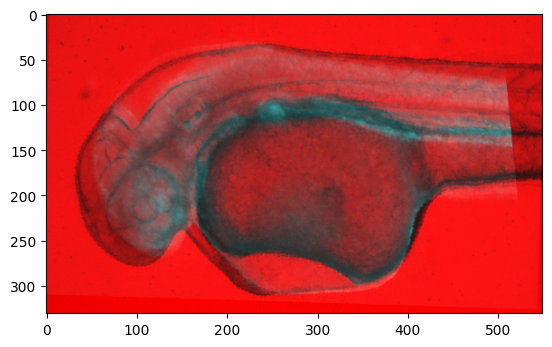

In [93]:
## Image and key points pairs
images_pairs = {
    'vis': (img_vis, np.array(keypointsA, dtype=np.float32)),
    'cfp': (img_cfp, np.array(keypointsB, dtype=np.float32))
}
results = estimate_transform_and_overlap(images_pairs, method='euclidean')